Copyright 2019, Pavel Eftimovski, All rights reserved.

In [1]:
import os
import pandas as pd
import pandas_profiling as prof
import numpy as np
import seaborn as sns
import datetime as dt
from importlib import reload 
import random
from sklearn.decomposition import pca
from sklearn.ensemble import RandomForestClassifier
import ipynb.fs.full.USAID_support_functions as psf
reload(psf)
import warnings; 
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# import train data
files_path = 'C:/Users/Pavel/Desktop/USAID_Data/train_test/train/'

feat_names =['item_desc_tr', 'ctry_tr',
             'vendor_tr', 'manu_site_tr',
             'brand_tr', 'mol_test_tr',
             'num_log_tr', 'datetime64_tr',
             'objects_tr', 'trending_tr']

file_dict = psf.import_sel_data(files_path, feat_names)

print(file_dict.keys(), "\n", [df.shape for df in file_dict.values()])

for key, df in file_dict.items():
    print("\n", key, ":\n", df.dtypes)

item_desc, ctry_fs, vendor_fs, manu_site_fs, brand_fs, \
                mol_test_fs, num_log, datetime64, objects, trending = [file_dict[fn] for fn in feat_names]

dict_keys(['item_desc_tr', 'ctry_tr', 'vendor_tr', 'manu_site_tr', 'brand_tr', 'mol_test_tr', 'num_log_tr', 'datetime64_tr', 'objects_tr', 'trending_tr']) 
 [(8259, 8), (8259, 11), (8259, 11), (8259, 11), (8259, 11), (8259, 11), (8259, 24), (8259, 10), (8259, 61), (8259, 6)]

 item_desc_tr :
 unit_msr           int64
ln_itm_qty         int64
ln_itm_val       float64
pack_price       float64
unit_price       float64
line_item_ins    float64
real_w           float64
real_fc          float64
dtype: object

 ctry_tr :
 country_qtycount      int64
country_qtysum        int64
country_qtymean     float64
country_valsum      float64
country_valmean     float64
country_itemsum     float64
country_itemmean    float64
country_wsum        float64
country_wmean       float64
country_fcsum       float64
country_fcmean      float64
dtype: object

 vendor_tr :
 vendor_qtycount      int64
vendor_qtysum        int64
vendor_qtymean     float64
vendor_valsum      float64
vendor_valmean     float64
vendor_

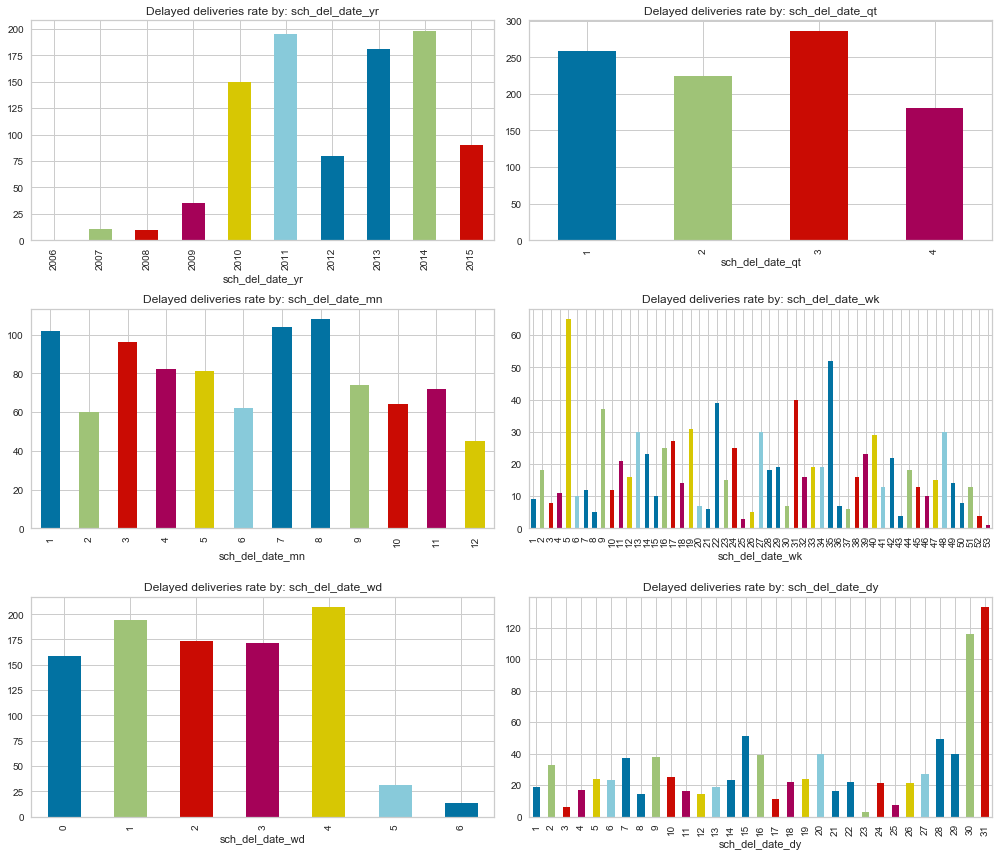

In [3]:
# plot avg. delays by periods
del_objcts = objects.loc[:,[c for c in objects.columns if "del" in c]]
for c in del_objcts:
    del_objcts[c] = pd.to_numeric(del_objcts[c])
    
# Plot
sch_cols = ['sch_del_date_yr','sch_del_date_qt',
            'sch_del_date_mn', 'sch_del_date_wk',
            'sch_del_date_wd', 'sch_del_date_dy'] 

fig, ((ax0,ax1), (ax2,ax3),(ax4,ax5)) = plt.subplots(nrows=3,ncols=2,figsize=(10,10))
axes = [ax0,ax1, ax2,ax3,ax4,ax5]

for i in range(len(sch_cols)):
    del_objcts.groupby(sch_cols[i]).agg('sum')['delayed_del'].plot(
                                                        kind="bar",
                                                        ax=axes[i],
                                                        title = "Delayed deliveries rate by: "+sch_cols[i],
                                                        figsize = (14, 12))
    
plt.tight_layout()

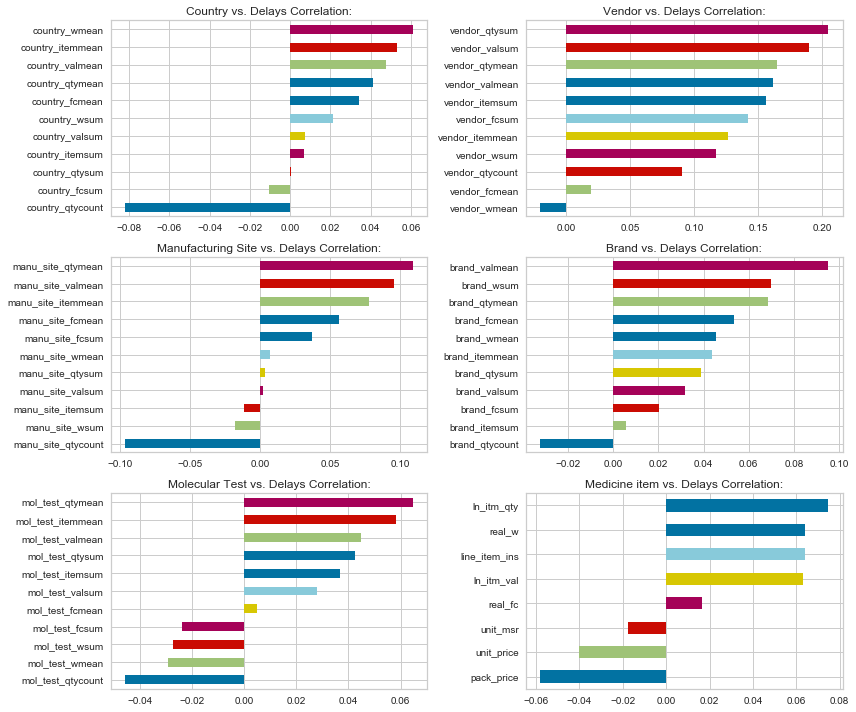

In [4]:
# num features corr. with delayed deliveries
sel_nfeat = [ctry_fs, vendor_fs,
             manu_site_fs, brand_fs,
             mol_test_fs, item_desc]

plot_names = ['Country', 'Vendor',
              'Manufacturing Site',
              'Brand', 'Molecular Test',
              'Medicine item']

delayed_del=pd.to_numeric(objects.delayed_del)
        
fig, ((ax0, ax1),(ax2,ax3),(ax4,ax5))= plt.subplots(nrows=3,ncols=2,figsize=(12,10))
axes = [ax0, ax1,ax2,ax3,ax4,ax5]

for i in range(len(sel_nfeat)):
    pd.concat([sel_nfeat[i], delayed_del], axis=1).corr().delayed_del.drop(
                                            "delayed_del").sort_values().plot(
                                            kind='barh',
                                            title= plot_names[i]+" vs. Delays Correlation:",
                                            ax = axes[i])
plt.tight_layout()

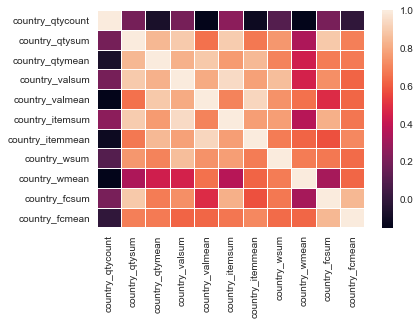

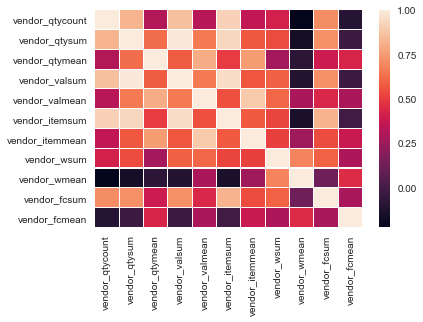

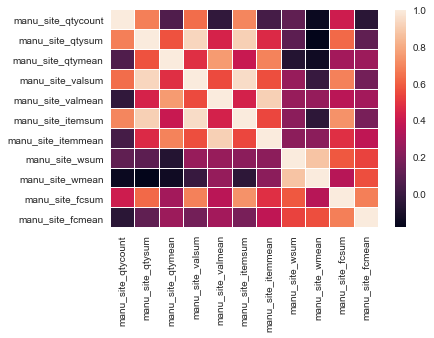

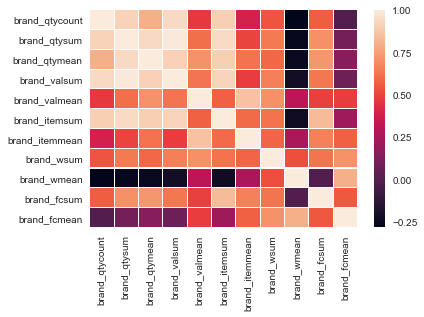

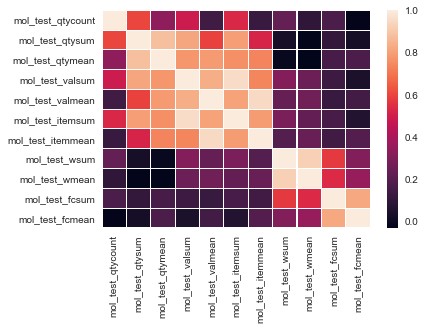

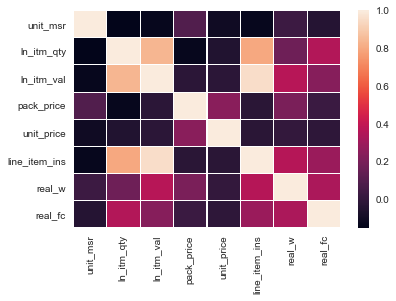

In [5]:
# num features auto-corr
for i in range(len(sel_nfeat)):
    a, b = plt.subplots(1, 1, figsize=(6,4))
    sns.heatmap(sel_nfeat[i].corr(), linewidths=.02)

In [6]:
# num features selection

# ctry_fs
s_ctry = ['country_qtycount', 'country_valmean', 'country_wmean']

# vendor_fs
s_vendor = ['vendor_qtysum', 'vendor_qtymean',
            'vendor_valsum', 'vendor_valmean',
            'vendor_fcsum', 'vendor_wsum']

# manu_site_fs
s_msite = ['manu_site_qtycount', 'manu_site_qtymean']

# brand_fs
s_brand = ['brand_valmean']

# mol_test_fs
s_molt = ['mol_test_qtycount', 'mol_test_itemmean']

# item_desc
s_item = ['ln_itm_qty', 'ln_itm_val',
          'pack_price','line_item_ins','real_w']

si, sc, sv, sm, sb, sml = item_desc[s_item],ctry_fs[s_ctry], vendor_fs[s_vendor] \
                                ,manu_site_fs[s_msite], brand_fs[s_brand],mol_test_fs[s_molt]

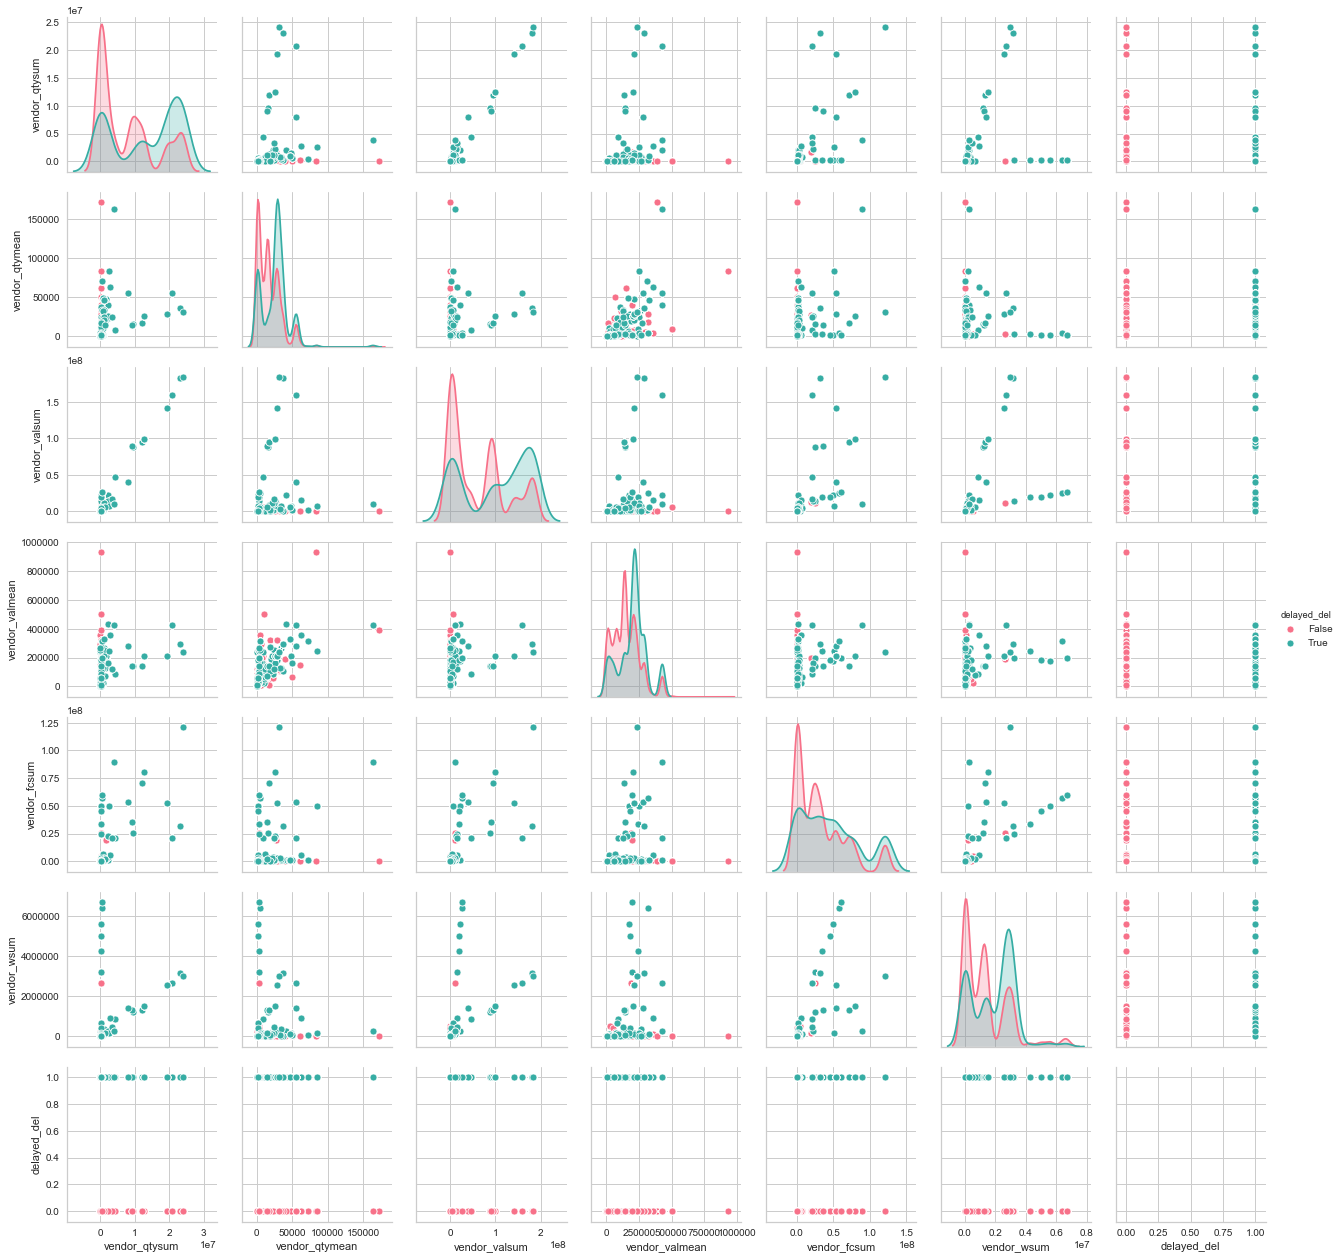

In [7]:
# vendor features further exploration
sns.pairplot(pd.concat([sv, objects.delayed_del],axis=1),
                                        hue="delayed_del",
                                        diag_kind="kde",
                                        palette="husl")

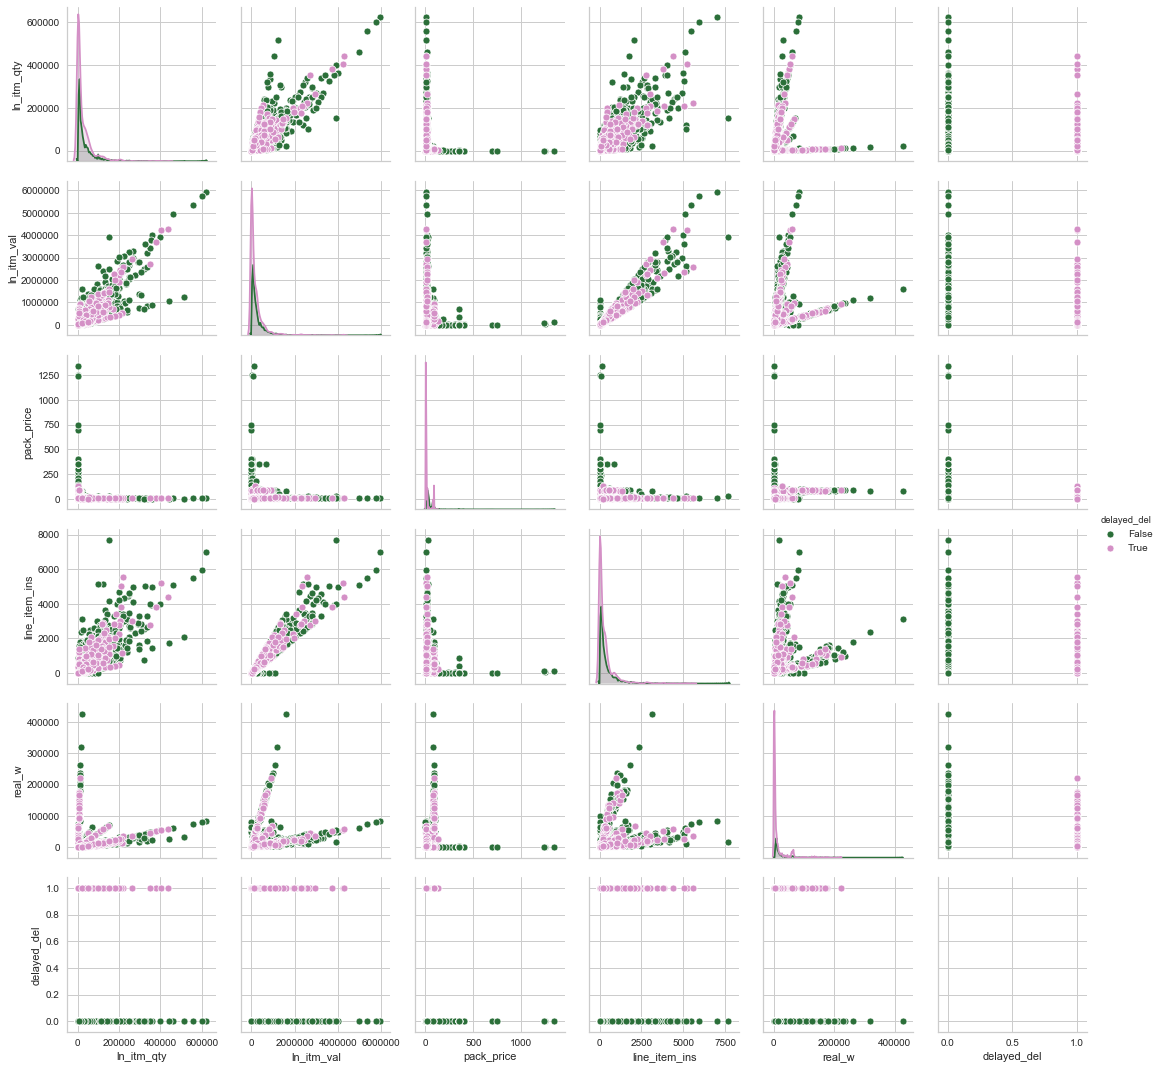

In [8]:
# item features further exploration
sns.pairplot(pd.concat([si, objects.delayed_del],axis=1),
                                        hue="delayed_del",
                                        diag_kind="kde",
                                        palette = 'cubehelix')

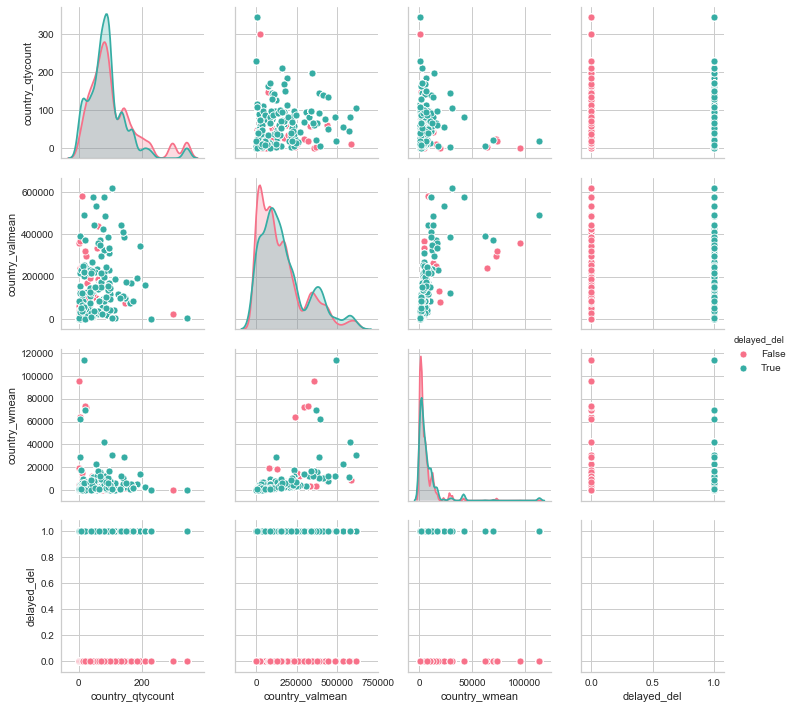

In [9]:
# country features further exploration
sns.pairplot(pd.concat([sc, objects.delayed_del],axis=1),
                                        hue="delayed_del",
                                        diag_kind="kde",
                                        palette = 'husl')

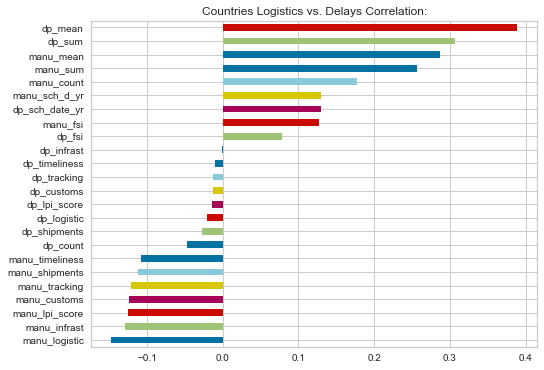

In [10]:
# destinations/manufacturers corr with delays
#num_log.dtypes
pd.concat([num_log, delayed_del],axis=1).corr()['delayed_del'].drop(
                            'delayed_del', axis=0).sort_values().plot(
                                                         kind="barh",
                                                         title="Countries Logistics vs. Delays Correlation:",
                                                         figsize=(8,6))

In [11]:
pd.concat([num_log, delayed_del],axis=1).corr()['delayed_del'].drop('delayed_del', axis=0).sort_values()

manu_logistic     -0.147263
manu_infrast      -0.128497
manu_lpi_score    -0.125276
manu_customs      -0.123350
manu_tracking     -0.121585
manu_shipments    -0.112568
manu_timeliness   -0.107550
dp_count          -0.047587
dp_shipments      -0.027638
dp_logistic       -0.021283
dp_lpi_score      -0.014607
dp_customs        -0.012840
dp_tracking       -0.012413
dp_timeliness     -0.010711
dp_infrast        -0.001126
dp_fsi             0.077741
manu_fsi           0.126801
dp_sch_date_yr     0.129977
manu_sch_d_yr      0.129977
manu_count         0.176675
manu_sum           0.256813
manu_mean          0.287306
dp_sum             0.306148
dp_mean            0.388657
Name: delayed_del, dtype: float64

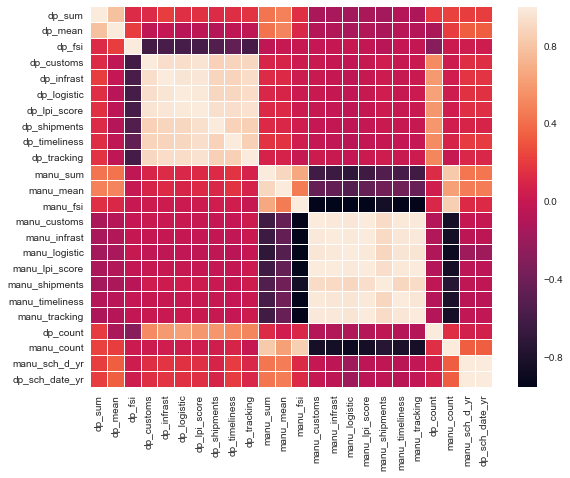

In [12]:
# delivery points/manufacturers auto-corr
a, b = plt.subplots(1, 1, figsize=(9,7))
sns.heatmap(num_log.corr(), linewidths=.02)

In [13]:
# num_log features selection
s_num = ['manu_logistic', 'manu_infrast'
         , 'manu_lpi_score', 'manu_customs'
         , 'manu_tracking', 'manu_shipments'
         , 'manu_timeliness', 'manu_fsi'
         , 'dp_shipments', 'dp_timeliness'
         , 'dp_tracking', 'dp_customs'
         , 'dp_lpi_score', 'dp_infrast'
         , 'dp_logistic','dp_count'
         , 'dp_fsi']

s_num_log = num_log[s_num]

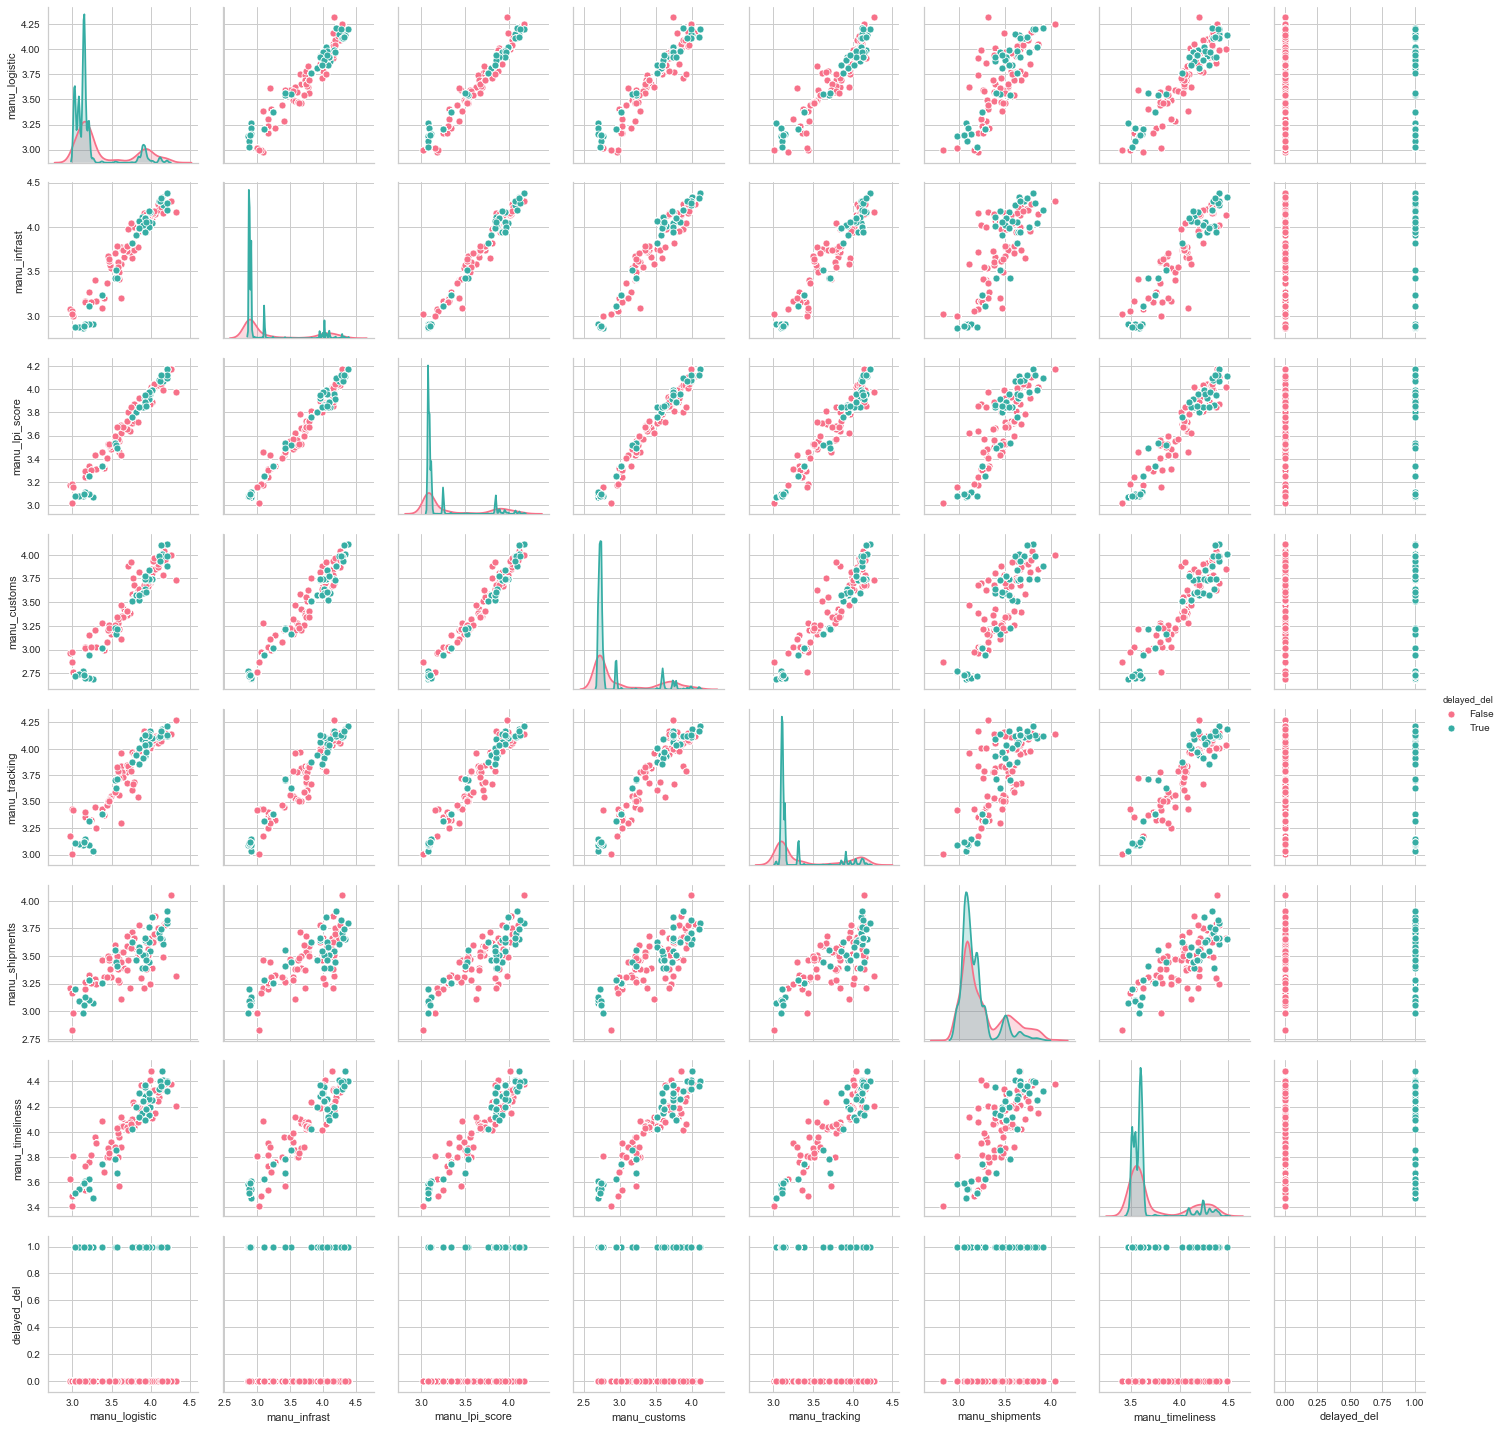

In [14]:
# num_log features further exploration
sns.pairplot(pd.concat([s_num_log.iloc[:, :7], objects.delayed_del],axis=1),
                                        hue="delayed_del",
                                        diag_kind="kde",
                                        palette = 'husl')

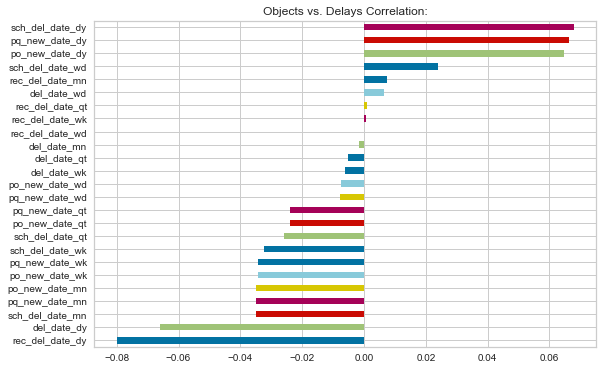

In [15]:
# objects corr with delays
objects2 = objects.drop(['delayed_del'], axis=1).copy()

# drop year features
for feature in objects2:
    if feature.endswith("_yr"): objects2.drop([feature], axis=1, inplace=True)

pd.concat([objects2, delayed_del],axis=1).corr()['delayed_del'].drop(
                                            'delayed_del', axis=0).sort_values().plot(
                                            kind="barh",
                                            title="Objects vs. Delays Correlation:",
                                            figsize=(9,6))

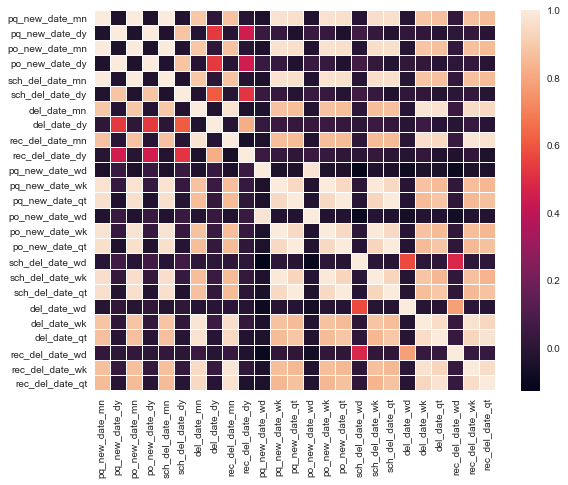

In [16]:
# objects auto-corr
a, b = plt.subplots(1, 1, figsize=(9,7))
sns.heatmap(objects2.corr(), linewidths=.02)

In [17]:
# objects features selection
s_o = ['po_new_date_mn', 'po_new_date_dy',
       'sch_del_date_mn', 'sch_del_date_dy',
       'po_new_date_wd', 'po_new_date_wk',
       'po_new_date_qt','sch_del_date_wd',
       'sch_del_date_wk','sch_del_date_qt',
       'managed_by', 'flf_via', 'vendor',
       'ship_mode', 'product_grp', 'sub_class',
       'mol_test', 'brand', 'dosage', 'dos_form',
       'manu_site', 'first_line','c_ship',
       'sep_weight', 'sep_freight',
       'cmdty_cost_freight', 'country',
       'manu_country', 'manu_continent']

objects = objects.apply(lambda elem: pd.Categorical(elem)) # convert to category
s_objects = objects[s_o]
s_objects.columns

Index(['po_new_date_mn', 'po_new_date_dy', 'sch_del_date_mn',
       'sch_del_date_dy', 'po_new_date_wd', 'po_new_date_wk', 'po_new_date_qt',
       'sch_del_date_wd', 'sch_del_date_wk', 'sch_del_date_qt', 'managed_by',
       'flf_via', 'vendor', 'ship_mode', 'product_grp', 'sub_class',
       'mol_test', 'brand', 'dosage', 'dos_form', 'manu_site', 'first_line',
       'c_ship', 'sep_weight', 'sep_freight', 'cmdty_cost_freight', 'country',
       'manu_country', 'manu_continent'],
      dtype='object')

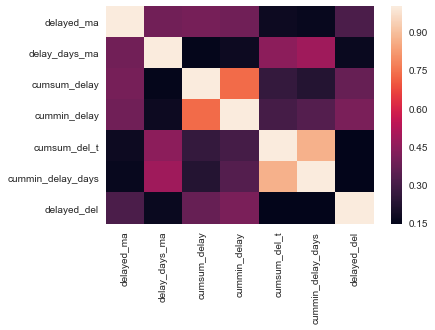

In [18]:
# trending - time series correlation
sns.heatmap(pd.concat([trending, objects['delayed_del'].map({False:0, True:1})], axis=1).corr())

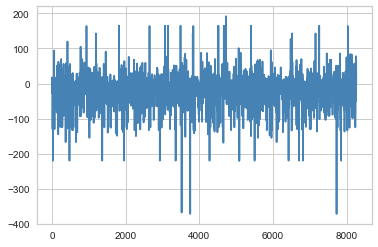

In [21]:
# plot frequency
datetime64['delay_t'] = datetime64['delay_t'].apply(lambda elem: pd.to_timedelta(elem))
(pd.to_numeric(datetime64['delay_t'])/(1e9*3600*24)).plot(color='steelblue')

In [24]:
# Pipeline engineering
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.pipeline import make_pipeline

log_transform = FunctionTransformer(np.log1p)
log_stand_pipeline = make_pipeline(log_transform, StandardScaler()) 
stand_pipeline = make_pipeline(StandardScaler()) 
lab_pipeline = make_pipeline(psf.LabelBiner())
one_hot_pipeline = make_pipeline(psf.OneHotEncoder())
        
ti, tc, tv, tm, tb, tml = [pd.DataFrame(log_stand_pipeline.fit_transform(d)
                                        , index=d.index
                                        , columns=d.columns) for d in [si, sc, sv, sm, sb, sml]]

t_num_log = pd.DataFrame(stand_pipeline.fit_transform(s_num_log)
                                       , index=s_num_log.index
                                       ,columns=s_num_log.columns)

tt = pd.DataFrame(stand_pipeline.fit_transform(trending)
                                       , index=trending.index
                                       , columns=trending.columns)

delayed_del = lab_pipeline.fit_transform(objects.delayed_del.map({True:1, False:0}))

try:
    s_objects.drop('delayed_del', axis=1, inplace=True)
except:
    pass

t_objects = one_hot_pipeline.fit_transform(s_objects)

t_data = pd.concat([t_objects, t_num_log, ti, tc, tv, tm, tb, tml, tt], axis=1)

print(t_data.shape)

(8259, 684)


In [25]:
# check for nulls
for i, value in t_data.isnull().sum().items():
    if value > 0: print(i)
        
psf.fix_nulls(t_data) # fix nulls

delayed_ma
delay_days_ma



Variance by component:
 [0.1782091  0.13873795 0.07913225 0.05776279] 

Total Variance:
 0.45384209723171753


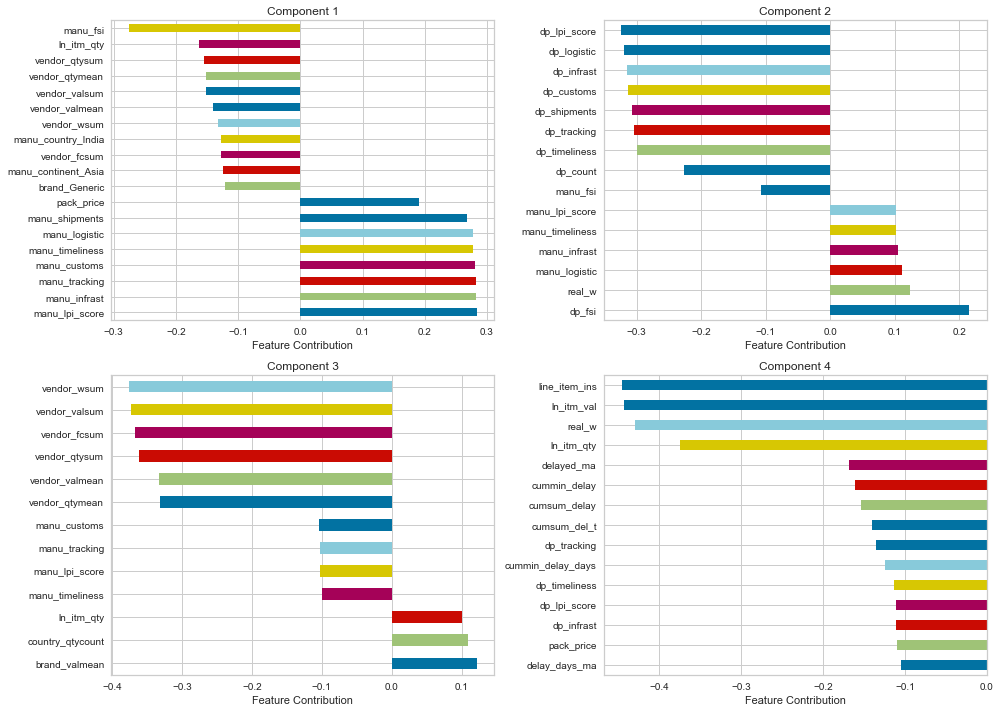

In [26]:
# Principal component analyis
pca_ed = pca.PCA(n_components=4)
pca_ed.fit(t_data)
pca_ed.transform(t_data)

print( "\nVariance by component:\n {} \n\nTotal Variance:\n {}" 
    .format(pca_ed.explained_variance_ratio_,pca_ed.explained_variance_ratio_.sum()))

psf.describe_pca(t_data, pca_ed)
plt.tight_layout()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=103, verbose=0, warm_start=False)

Total  importance    0.539478
dtype: float64


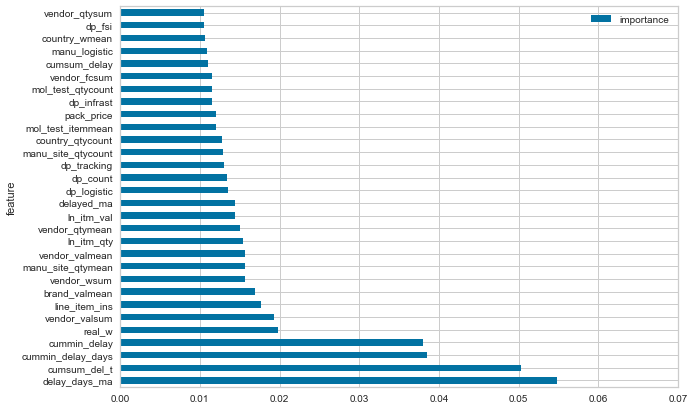

In [27]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(random_state=103)
X,y = t_data, delayed_del  
random_forest.fit(X,y)
print(random_forest)

features = X.columns
major_features = pd.DataFrame(random_forest.feature_importances_, features)

major_features.reset_index(inplace=True)
major_features.columns=['feature', 'importance']

major_features.set_index('feature').sort_values('importance', ascending=False)[:30].plot(
                                                                                kind="barh",
                                                                                xlim=(0,0.07),
                                                                                figsize=(10,7))

print("\nTotal ", major_features.set_index('feature').sort_values(
                                    'importance', ascending=False)[:30].sum())

In [28]:
# export selected train features
e_path = 'C:/Users/Pavel/Desktop/USAID_Data/selected features/'

predictors = [s_objects,
              s_num_log,
              si, sc, sv,
              sm, sb, sml,
              trending,
              objects,
              datetime64]

pred_names = ['s_objects',
              's_num_log',
              'si', 'sc',
              'sv','sm',
              'sb', 'sml',
              'trending']

for i in range(len(pred_names)):
    #predictors[i].to_csv(e_path + 'train/predictors/' + pred_names[i] + '.csv', index=False)

# export responses
# pd.DataFrame(objects['delayed_del']).to_csv(e_path + 'train/responses/' + 'delayed_del.csv', index=False) 
# datetime64.to_csv(e_path + 'train/responses/'+ 'datetime64.csv', index=False) 

In [30]:
#select test features
test_path = 'C:/Users/Pavel/Desktop/USAID_Data/train_test/test/'

ts_feat_names =['item_desc_ts',
                'ctry_ts',
                'vendor_ts',
                'manu_site_ts',
                'brand_ts',
                'mol_test_ts',
                'num_log_ts',
                'datetime64_ts',
                'objects_ts',
                'trending_ts']

test_dict = psf.import_sel_data(test_path, ts_feat_names)

print(test_dict.keys(), "\n", [df.shape for df in test_dict.values()])

for key, df in test_dict.items():
    print("\n", key, ":\n", df.dtypes)

item_desc_ts, ctry_ts, vendor_ts, manu_site_ts, brand_ts, mol_test_ts\
        , num_log_ts, datetime64_ts, objects_ts, trending_ts = [test_dict[fn] for fn in ts_feat_names]

sti, stc, stv, stm, stb, stml = item_desc_ts[s_item], ctry_ts[s_ctry], vendor_ts[s_vendor] \
                                ,manu_site_ts[s_msite], brand_ts[s_brand], mol_test_ts[s_molt]

s_ts_num_log = num_log_ts[s_num]
s_ts_objects = objects_ts[s_o]

# export predictors
ts_predictors = [s_ts_objects,
                 s_ts_num_log,
                 sti, stc, stv,
                 stm, stb, stml,
                 trending_ts]

ts_pred_names = ['s_ts_objects',
                 's_ts_num_log',
                 'sti', 'stc',
                 'stv', 'stm',
                 'stb', 'stml',
                 'trending_ts']

for i in range(len(ts_pred_names)):
    #ts_predictors[i].to_csv(e_path + 'test/predictors/' +  ts_pred_names[i]+".csv", index=False)

# export responses
# pd.DataFrame(objects_ts['delayed_del']).to_csv(e_path + 'test/responses/' + 'delayed_del_ts.csv', index=False) 
# datetime64_ts.to_csv(e_path + 'test/responses/'+ 'datetime64_ts.csv', index=False) 

dict_keys(['item_desc_ts', 'ctry_ts', 'vendor_ts', 'manu_site_ts', 'brand_ts', 'mol_test_ts', 'num_log_ts', 'datetime64_ts', 'objects_ts', 'trending_ts']) 
 [(2065, 8), (2065, 11), (2065, 11), (2065, 11), (2065, 11), (2065, 11), (2065, 24), (2065, 10), (2065, 61), (2065, 6)]

 item_desc_ts :
 unit_msr           int64
ln_itm_qty         int64
ln_itm_val       float64
pack_price       float64
unit_price       float64
line_item_ins    float64
real_w           float64
real_fc          float64
dtype: object

 ctry_ts :
 country_qtycount      int64
country_qtysum        int64
country_qtymean     float64
country_valsum      float64
country_valmean     float64
country_itemsum     float64
country_itemmean    float64
country_wsum        float64
country_wmean       float64
country_fcsum       float64
country_fcmean      float64
dtype: object

 vendor_ts :
 vendor_qtycount      int64
vendor_qtysum        int64
vendor_qtymean     float64
vendor_valsum      float64
vendor_valmean     float64
vendor_